### Recommender Systems:  Collaborative Filtering with Embeddings and Neural Network


#### import libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Add, Activation, Lambda
from keras.layers import Concatenate, Dense, Dropout

from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


#### load data

In [2]:
ratings = pd.read_csv('Data/ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv('Data/movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Data Exploration

To get a better sense of what the data looks like, we can turn it into a table by selecting the top 15 users/movies from the data and joining them together. The result shows how each of the top users rated each of the top movies.

In [4]:
#### top 15 user ID per ratings from the ratings data

g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

top_users.head()

userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: rating, dtype: int64

In [5]:
#### top 15 movies with the higest ratings
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_movies.head()

movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64

In [6]:
#### merge both top data into a table

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

top_r.head()

,userId,movieId,rating,timestamp,rating_r,rating_r
10360,68,1,2.5,1158531426,1260,215
26092,182,1,4.0,1063289621,977,215
36374,249,1,4.0,1347317775,1046,215
39229,274,1,4.0,1171410158,1346,215
42114,288,1,4.5,1054568869,1055,215


In [7]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


####  LabelEncoder

- Use scikit-learn’s LabelEncoder class to transform the `user/movie` fields which are currently non-sequential integer to sequential data (starting at zero).

- We’ll also create variables with the total number of unique users and movies in the data, as well as the `min and max ratings` present in the data


In [8]:
user_enc = LabelEncoder()

ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

n_users

610

In [9]:
item_enc = LabelEncoder()

ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()

n_movies

9724

In [10]:
ratings['rating'] = ratings['rating'].values.astype(np.float32)

min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

In [11]:
min_rating

0.5

In [12]:
max_rating

5.0

#### View the final processed data for training

In [13]:
ratings.head(7)

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46
5,1,70,3.0,964982400,0,62
6,1,101,5.0,964980868,0,89


#### Create train and test set


In [14]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("Training Data Size:", X_train.shape)
print("Training Label Size:", y_train.shape)
print()
print("Test Data Size:", X_test.shape)
print("Test Label Size:", y_test.shape)

Training Data Size: (90752, 2)
Training Label Size: (90752,)

Test Data Size: (10084, 2)
Test Label Size: (10084,)


In [15]:
#### Finally, we need to turn users and movies into separate arrays in the training and test data.
#### Since Keras needs distinct inputs, feed each input as its own array.

X_train_array = [X_train[:, 0], X_train[:, 1]]

X_test_array = [X_test[:, 0], X_test[:, 1]]

#### Number of factors

- Another constant we’ll need for the model is the number of factors per user/movie. 50 seemed to work pretty well.

In [16]:
n_factors = 50

#### Model 1

- Using simple Embedding Layer alone

In [17]:
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    return model

In [18]:
model = RecommenderV1(n_users, n_movies, n_factors)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
___________

In [19]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))


Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 3s 32us/step - loss: 9.6864 - val_loss: 3.3205
Epoch 2/5
90752/90752 [==============================] - 3s 29us/step - loss: 2.0096 - val_loss: 1.6356
Epoch 3/5
90752/90752 [==============================] - 3s 30us/step - loss: 1.1150 - val_loss: 1.3516
Epoch 4/5
90752/90752 [==============================] - 3s 29us/step - loss: 0.8514 - val_loss: 1.2715
Epoch 5/5
90752/90752 [==============================] - 3s 29us/step - loss: 0.7215 - val_loss: 1.2375


In [20]:
print(history.history.keys())


dict_keys(['val_loss', 'loss'])


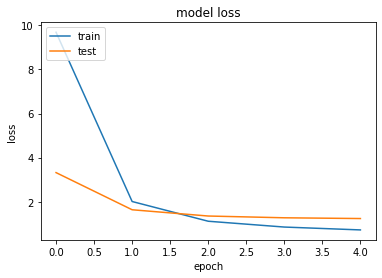

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 2: Embedding Layer & Bias

- Add bias to the Embedding Layer - using new embedding layers with a vector length of one

- The second improvement we can make is running the output of the dot product through a sigmoid layer and then scaling the result using the min and max ratings in the data. 

In [22]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        
        return x

In [23]:
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    return model

In [24]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

In [25]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 3s 38us/step - loss: 1.2081 - val_loss: 0.8674
Epoch 2/5
90752/90752 [==============================] - 3s 35us/step - loss: 0.7010 - val_loss: 0.7562
Epoch 3/5
90752/90752 [==============================] - 3s 36us/step - loss: 0.5271 - val_loss: 0.7338
Epoch 4/5
90752/90752 [==============================] - 3s 36us/step - loss: 0.3975 - val_loss: 0.7358
Epoch 5/5
90752/90752 [==============================] - 3s 38us/step - loss: 0.3050 - val_loss: 0.7523


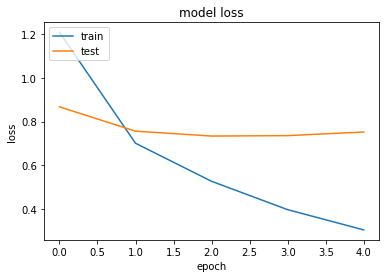

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model 3: Using Neural network and Embeddings

- Instead of taking the dot product of the embedding vectors, we just concatenate the embeddings together and stuck a fully-connected layer on top of them
- To modify the code, we can remove the bias embeddings from V2 and do a concat on the embedding layers instead.

In [27]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [28]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    return model

In [29]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        30500       input_5[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 50)        486200      input_6[0][0]                    
____________________________________________________________________________________________

In [30]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 4s 42us/step - loss: 0.9115 - val_loss: 0.7913
Epoch 2/5
90752/90752 [==============================] - 4s 42us/step - loss: 0.7630 - val_loss: 0.7738
Epoch 3/5
90752/90752 [==============================] - 4s 44us/step - loss: 0.7275 - val_loss: 0.7794
Epoch 4/5
90752/90752 [==============================] - 4s 42us/step - loss: 0.7108 - val_loss: 0.7811
Epoch 5/5
90752/90752 [==============================] - 4s 45us/step - loss: 0.6982 - val_loss: 0.7880


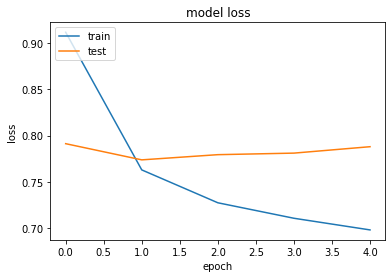

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()